### AJ Data Pre-Processing

In [1]:
import os
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import re
import csv
import json
import numpy as np
import tcxparser
import glob
import time
import statistics
import numpy
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

### Preprocess data

In [2]:
paths_to_data = {'fit':'../data/Fit/', 'arduino':'../data/Run/'}
data_dir = '../data/Run/'

path_to_tcx = 'Activities/*_Corsa.tcx'

file_names = sorted(glob.iglob(os.path.join(paths_to_data['fit'], path_to_tcx)))
distance_vec = [45]*22 # second number number of sessions 

In [3]:
def missing_data_treatment(data, method='interpolation'):
    """
    We see that the arduino app generates a lot of missing data points. We will implement a few different approaches to 
    deal with this missing data:
    :param method: (str) The methods we will implement are:
        - 'constant': Will adopt the value of the previous observation
        - 'interpolation': Interpolate the data since we are in a continuous domain
        - 'nearest': Adopts the value of the nearest value
    """
    df = data.copy()
    if method == 'interpolation':
        df.interpolate(method='linear', inplace=True)
    elif method == 'constant':
        df.interpolate(method='zero', inplace=True)
    elif method == 'nearest':
        df.interpolate(method='nearest', inplace=True)
    else:
        raise ValueError('The method specified is not defined. Please review function missing_data_treeatment')
    return df

In [4]:
def session_start(data, method='inference', value=None):
    """
    Sessions don't start in the moment in which Arduino starts recording data. There are a few residual seconds before
    we actually start running (e.g. setting up device). 
    We will implement 3 different methods:
    :param method: (str) 
        - 'inference': Look at the data and try to guess when we are actually starting to run. The idea until now is:
                - Look at the X, Y and Z axis for each user and see the most regular one (depends on how the device is placed).
                - Based on the best feature, estimate the average amplitude of a step (Avarage amplitude is calculated for each interval of n measurements)
                - Start is defined as the starting point of the first interval wich passes the avg threshold.
                - End is defined as the starting point of the first interval (from the end of the time series) wich passes the avg threshold.
                - Set the timer at the stage in which the amplitude is below a certain threshold
        - 'percentage': Remove the initial 2% of the observations (try to be conservative, better to remove part of the session
                        than keep irrelevant data)
        - 'fixed': Set a fixed starting point (not recommended but  can be usefull for testing purposes)
    :param value: (depends) If the method is  inference leave the default value, if the method is percentage provide float 
                  between 0 and 1 (e.g. 0.02 to remove  2% of the initial data set), if the method is fixed provide a string 
                  with date format (e.g. '2021-05-02 18:01:00')
    """
    
    df = data.copy().dropna()
    if method == 'inference':
        
        n = 100 # n=100 seemed like a good compromise to me in order to avoid detecting local changes.
        Y = [abs(x) for x in df.AccY.tolist()]
        ampl = [statistics.mean(Y[x:x+n]) for x in range(1,(len(Y)//n)*n,n)]
        start = np.where(np.array(ampl) > statistics.mean(ampl))[0][0]*n
        end = np.where(np.array(ampl[::-1]) > statistics.mean(ampl))[0][0]*n
        start_timestamp = df.iloc[[start]].index[0]
        end_timestamp = df.iloc[[len(Y)-end-1]].index[0]
        print('Number of observations excluded with inference method:', start+end)
        
        ########################## to be deleted, just for check
        plt.figure(figsize=(20,8))
        plt.plot(df.AccY.tolist(),color='#F7EBE8')
        plt.axvline(x=start, color='g', linestyle='--')
        plt.axvline(x=len(Y)-end, color='r', linestyle='--')
        plt.show()
        #######################################################
        
        df = df[df.index > start_timestamp]
        df = df[df.index < end_timestamp]
        
    elif method == 'percentage':
        length = len(data)*value
        df = df[int(length):]
    elif method == 'fixed':
        df = df[df > value]
    else:
        raise ValueError('The method specified is not defined. Please review function session_start')
    
    return df

In [5]:
def identify_peaks(data, feature='AccY', height=0, distance=20, plot_check=[10000, 15000]):
    """
    For this function we provide a dataset and we return the same dataset with two additional features:
     - step: Indicator of when a set has been made. Since this estimation is based on the Acc it will in reality be 2 steps
     - peak_height: Moment in which the peak was identified, what was the height of the peak
    :param data: Dataframe where we will include the features
    :param feature: What is the feature variable over which this estimation will be done (this will depend on the run session)
    :param height: Reference value for peak_height
    :param distance: Minimum distance in index terms between two peaks. This is a tunning parameter which depends on the
        session
    :param plot_check: If provided, as output we will also get a plot to see whether the step checker has worked properly
    **Disclaimer: This is not an exact appproach, rather an approximation. Therefore this should be done ideally for each
        individual session independently
    """
   
    df = data.copy()
    x = np.array(df[feature])
    peaks, properties = find_peaks(x, height=height, distance=distance)
    if plot_check:
        plt.figure(figsize=(15, 8))
        plt.plot(x)
        plt.plot(peaks, x[peaks], "x")
        plt.plot(np.zeros_like(x), "--", color="gray")
        plt.xlim(plot_check[0], plot_check[1])
        plt.show()
   
    step = [0]*len(df)
    peak_height = [0]*len(df)
    j = 0
    for i in peaks:
        step[i] = 1
        peak_height[i] = properties['peak_heights'][j]
        j+=1

    df['step'] = step
    df['peak_height'] = peak_height
   
    return df

In [6]:
def df_aggregation(df, time_interval='5S', history=2):
   
    # Perform aggregation
    ind_df = df.groupby(pd.Grouper(freq=time_interval)).agg({'AccX':['min', 'max', 'mean', 'median', 'std'],
                                                        'AccY':['min', 'max', 'mean', 'median', 'std'],
                                                        'AccZ':['min', 'max', 'mean', 'median', 'std'],
                                                        'DecibelSource':['min', 'max', 'mean', 'median', 'std'],
                                                        #'PitchSensor':['min', 'max', 'mean', 'median', 'std'],
                                                        'LinearAccelerometerSensor':['min', 'max', 'mean', 'median', 'std'],
                                                        #'MagneticRotationSensor':['min', 'max', 'mean', 'median', 'std'],
                                                        #'CompassSensor':['min', 'max', 'mean', 'median', 'std'],
                                                        'step':['sum'],
                                                        'peak_height':['max'],
                                                        'pace':['min', 'max', 'mean', 'median', 'std']})
    ind_df.columns = ['_'.join(col).strip() for col in ind_df.columns.values]
    
    ind_df['step_sum'] = ind_df['step_sum'] / float(time_interval[:-1])
   
    # Now that aggregation is done we can get history variables which might be useful for prediction
    colnames = ind_df.columns.to_list()
    colnames.remove('step_sum')
    for feature in colnames:
        for i in range(history):
            ind_df[feature+'_previous_' + str(i+1)] = np.roll(ind_df[feature], i+1)
           
    ind_df = ind_df[history:]
   
    return ind_df

In [7]:
def generate_full_time_series_AJ(path, file_identifier='Run_', plot=None, google_files=file_names, period=1,
                                 independence_df=False, distance=distance_vec, feature='AccY', plot_check=[1000,1500],
                                 history=2, time_interval='5S'):
   
    """
    We have decided to generate a full time series as dataset (i.e. put all the sessions together, making several
    time series into a single one). For this purpose we will simply do individual pre-processing steps on each
    of the csv files and then merge everything together
    :param path: (str) Folder in which csv files can be found
    :param file_identifier: (str) Identifier of each csv file
    :param period: Number of periods between pace run
    :param independence_df: If true we will generate dataframes assuming independence
    :param distance: Used only for the step function detector
    :param feature: Used only for the step function detector
    :param plot_check: Used only for the step function detector
    :param history: How much back do we want to go to remove independence?
    """
    session_files =  [i for i in os.listdir(path) if re.search(file_identifier, i)]
    full_df = pd.DataFrame()
   
    google_df = load_tcx(google_files)
    j=0
    for session in session_files:
        print('Session Identifier: ', re.findall('\d+', session)[0])
        df = pd.read_csv(path + session)
        df['timestamp'] = df.apply(lambda x: datetime.fromtimestamp(x['timestamp'] / 1000).strftime('%Y-%m-%d %H:%M:%S.%f')[:-3] ,axis=1)
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.set_index('timestamp')
        df['AccY'] = df['AccY'] * -1
        df_missing = missing_data_treatment(df, method='interpolation')
        df_start = session_start(df_missing, method='inference',value=None)
        #print('Session Start: ' + str(min(df_start.index)))
        #print('Session End: ' + str(max(df_start.index)))
        reduce_tcx_df = google_df[(google_df.timestamp > str(min(df_start.index))) &
                                  (google_df.timestamp < str(max(df_start.index)))].set_index('timestamp')
       
       
        #return reduce_tcx_df, df_start
        # Intermediate step to remove google data duplicates for distance and altitude seperately
        reduce_tcx_df.reset_index(level=0, inplace=True)
        dist_df = reduce_tcx_df.groupby('distance').last().reset_index(level=0).set_index('timestamp')
        alt_df = reduce_tcx_df.groupby('altitude').last().reset_index(level=0).set_index('timestamp')
       
        merged = df_start.merge(dist_df[['distance', 'google_fit']], how='outer', sort=True, on='timestamp')
        merged['distance'] = merged['distance'].interpolate(method='index')
       
        merged = merged.merge(alt_df[['altitude', 'google_fit']], how='outer', sort=True, on='timestamp')
        merged['altitude'] = merged['altitude'].interpolate(method='index')
       
       
        df_final = merged[~(merged.google_fit_x == True) | ~(merged.google_fit_y == True)]
        #df_final.dropna(subset=['altitude', 'distance'], inplace=True)
        df_final.drop(columns=['google_fit_x', 'google_fit_y'], inplace=True)
        df_final = df_final[(df_final.index > str(min(df_start.index))) &
                             (df_final.index < str(max(df_start.index)))]
       
        # Add pace to as feature
        df_final['delta_distance']= df_final.distance.diff(periods=period)
        df_final['delta_time'] = [0]*period+[(df_final.index[i]-df_final.index[i-period]).total_seconds()
                                                for i in range(period,df_final.shape[0])]
        df_final = df_final[period:]
        df_final['pace']=(df_final.delta_distance/1000)/(df_final.delta_time/3600)
       
        if independence_df:
            df_peaks = identify_peaks(df_final, feature=feature, plot_check=plot_check, distance=distance_vec[j])
            df_agg = df_aggregation(df_peaks, time_interval=time_interval, history=history)
            df_agg.dropna(inplace=True)
            full_df = pd.concat([full_df, df_agg])
        else:
            full_df = pd.concat([full_df, df_final])        
        print('+++++++++++++++')
        j+=1
       
    print('Finished pre-processing individual time series')
    full_df.sort_values(by='timestamp', inplace=True)
   
    if plot:
        plt.figure(figsize=(20, 12))
        plt.plot(full_df[plot])
        plt.show()
     
   
    return full_df


In [8]:
def load_tcx(file_list):
   
    """
    Load tcx files into pandas DataFrame
    
    Known issue: 
    the lists altitude, timestamp and distance have not the same length;
    we don't know the position of the missing data (potential values' shift);
    """
    df = pd.DataFrame(columns=['timestamp','altitude',
                               'distance', 
                               'google_fit'])
    
    for file in file_list:
        tcx_obj = tcxparser.TCXParser(file)
        default_len = min([len(tcx_obj.time_values())],
                          [len(tcx_obj.altitude_points())],
                          [len(tcx_obj.distance_values())])[0]
        data_dict = {'timestamp':tcx_obj.time_values()[-default_len:], 
                     'altitude':tcx_obj.altitude_points()[-default_len:], 
                     'distance':tcx_obj.distance_values()[-default_len:],
                     'google_fit': [True] * default_len}
        tmp_df = pd.DataFrame.from_dict(data_dict)
        df = pd.concat([df, tmp_df], ignore_index=True)
        print('======================')
        
    df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%dT%H:%M:%S.%fZ")
    hours_added = timedelta(hours = 2)
    df['timestamp'] = df['timestamp'] + hours_added
    df['distance'] = pd.to_numeric(df.distance.astype(str))
        
    return df.sort_values(by='timestamp')

Generate the preprocessed data

Session Identifier:  9
Number of observations excluded with inference method: 2500


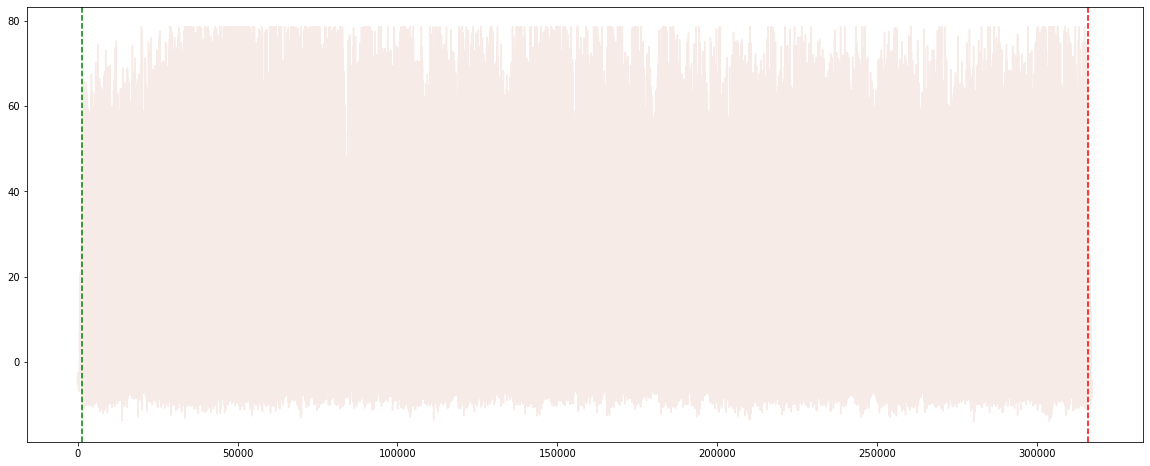

/home/stefano/Documents/University/Master/SL/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


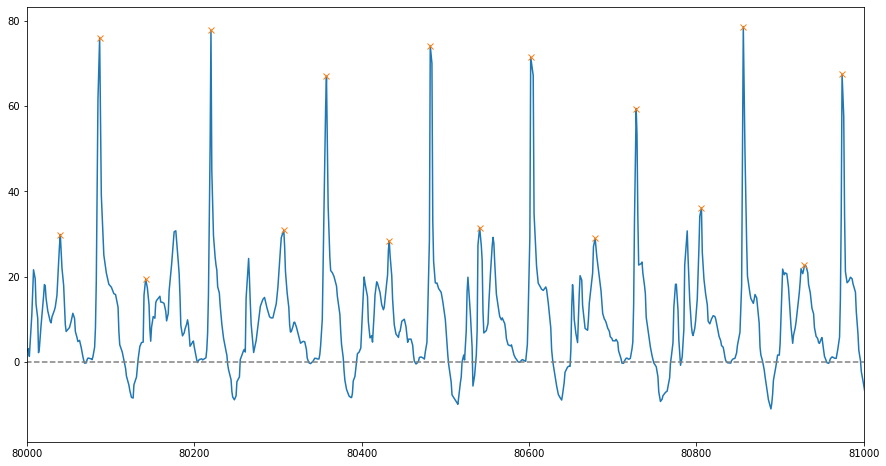

+++++++++++++++
Session Identifier:  3
Number of observations excluded with inference method: 3800


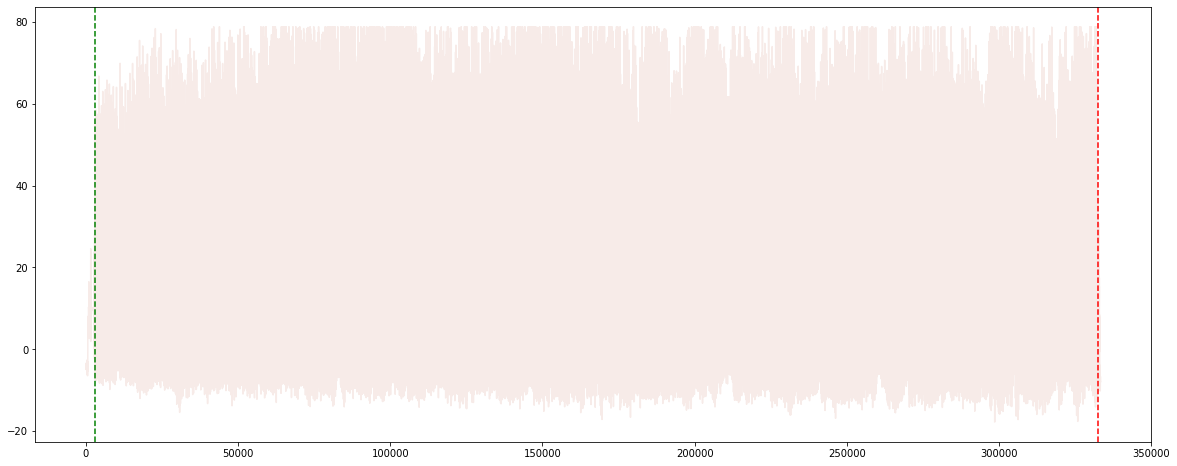

/home/stefano/Documents/University/Master/SL/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


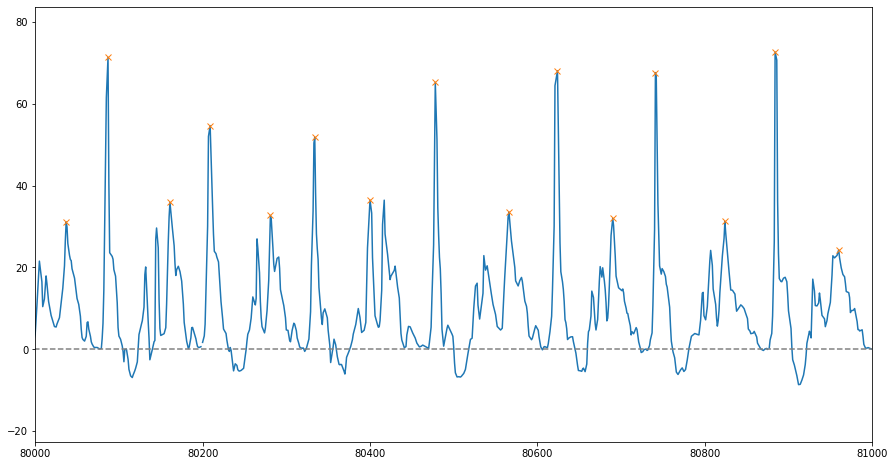

+++++++++++++++
Session Identifier:  8
Number of observations excluded with inference method: 4000


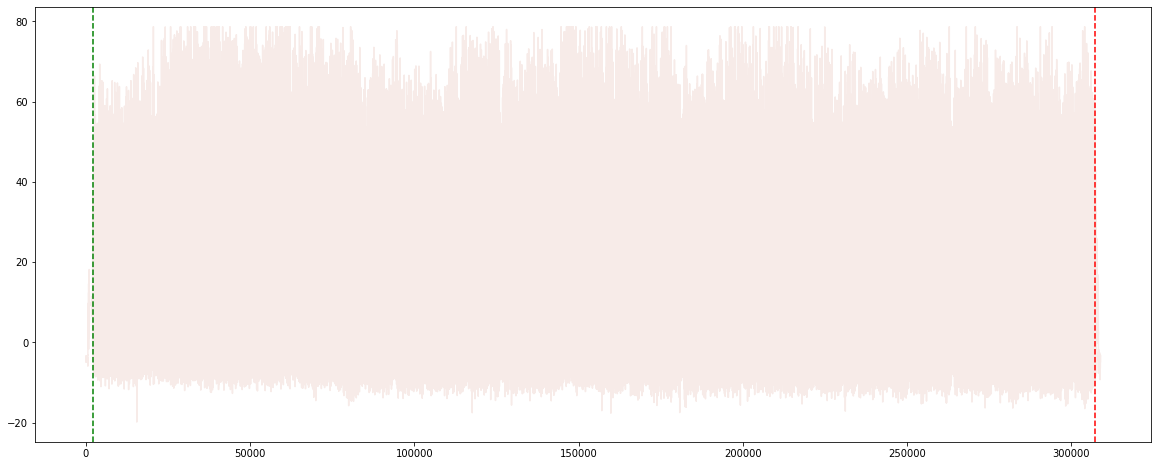

/home/stefano/Documents/University/Master/SL/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


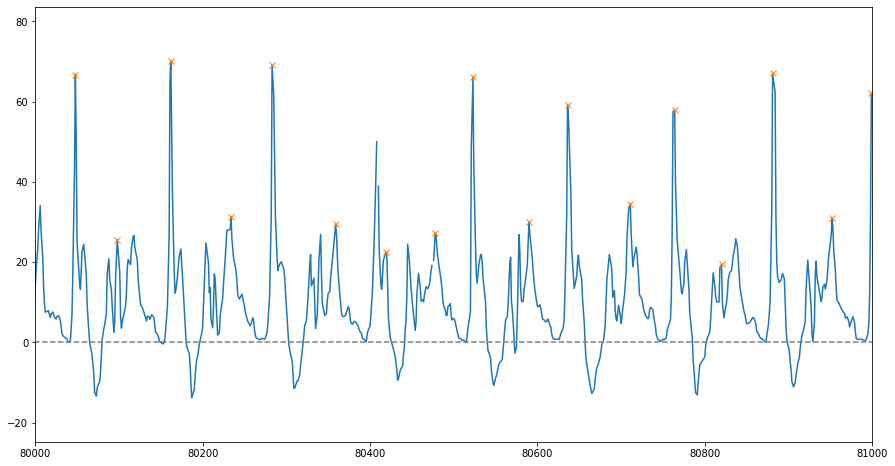

+++++++++++++++
Session Identifier:  4
Number of observations excluded with inference method: 3200


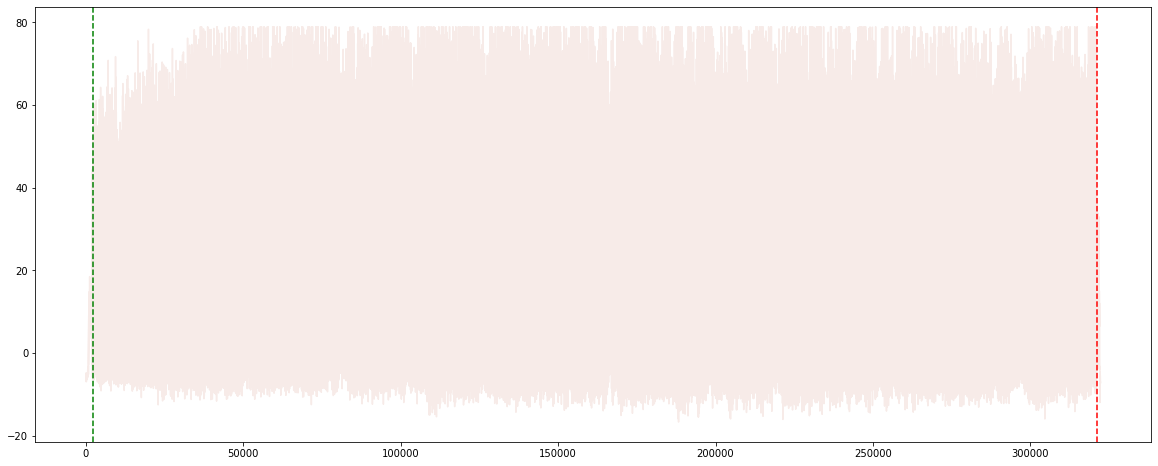

/home/stefano/Documents/University/Master/SL/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


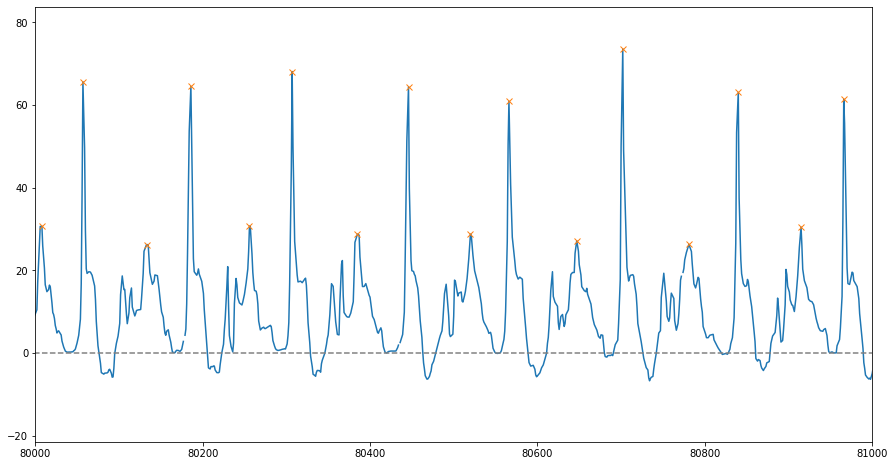

+++++++++++++++
Session Identifier:  12
Number of observations excluded with inference method: 2500


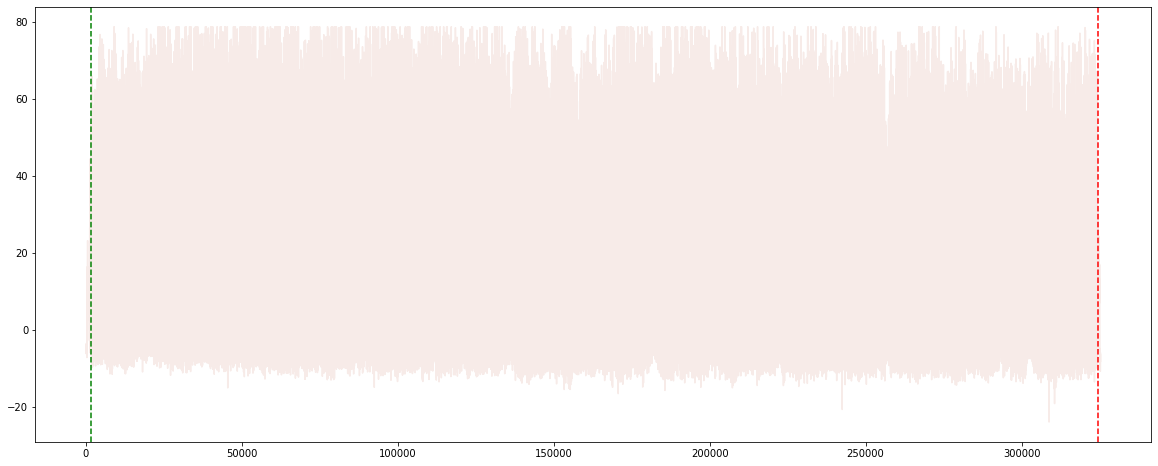

/home/stefano/Documents/University/Master/SL/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


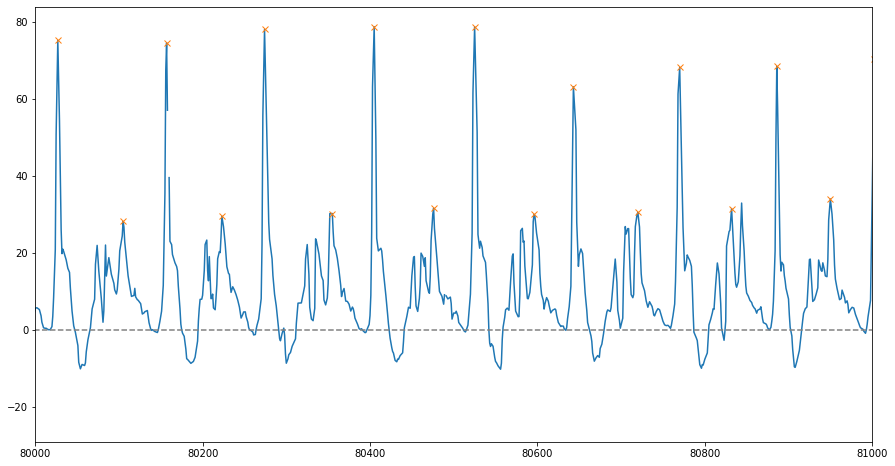

+++++++++++++++
Session Identifier:  17
Number of observations excluded with inference method: 4200


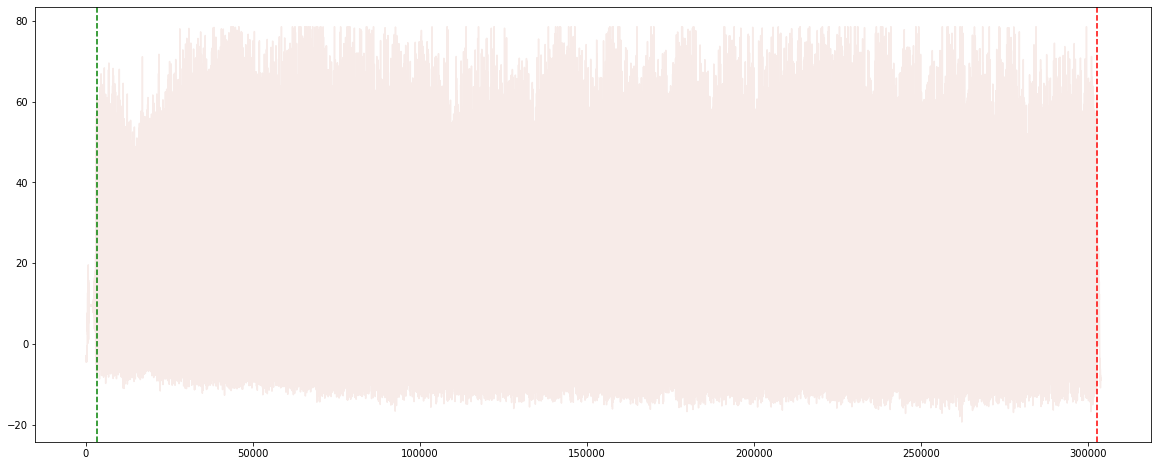

/home/stefano/Documents/University/Master/SL/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


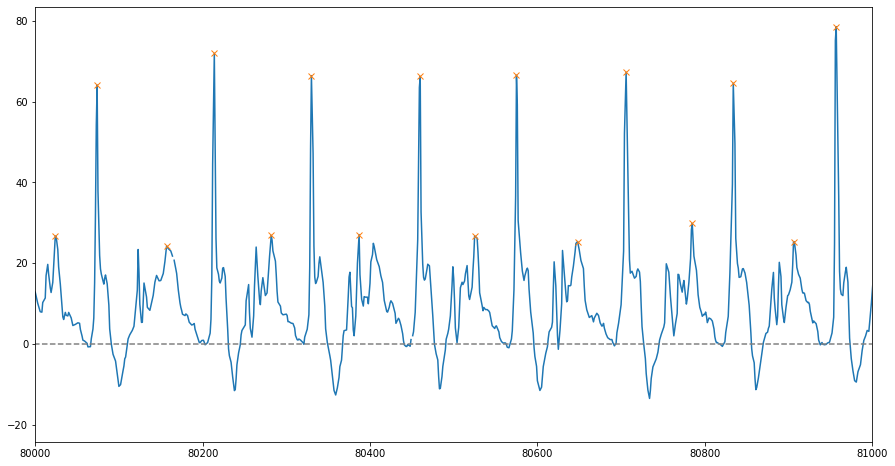

+++++++++++++++
Session Identifier:  5
Number of observations excluded with inference method: 3900


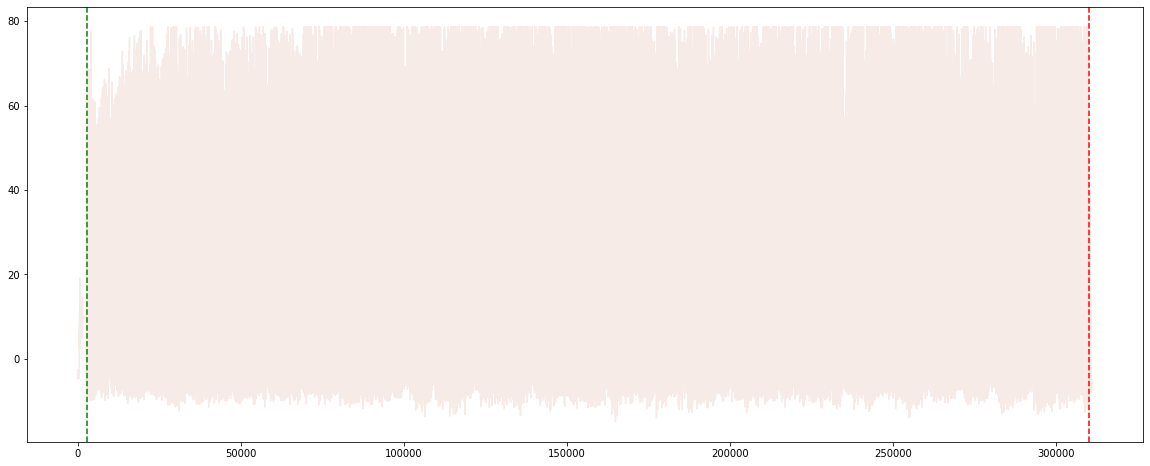

/home/stefano/Documents/University/Master/SL/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


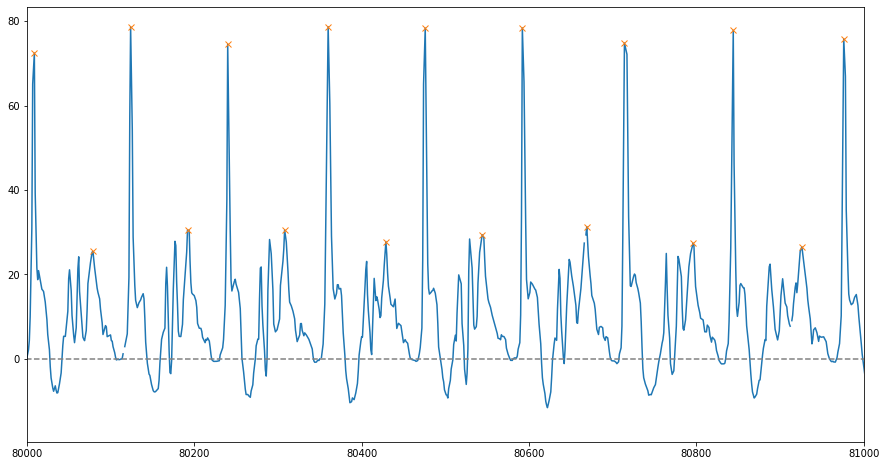

+++++++++++++++
Session Identifier:  2
Number of observations excluded with inference method: 2300


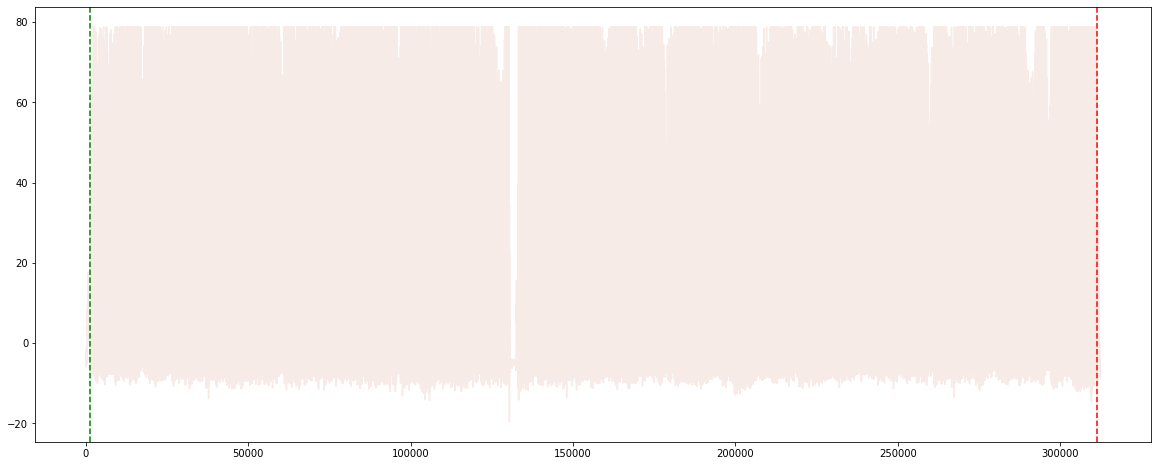

/home/stefano/Documents/University/Master/SL/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


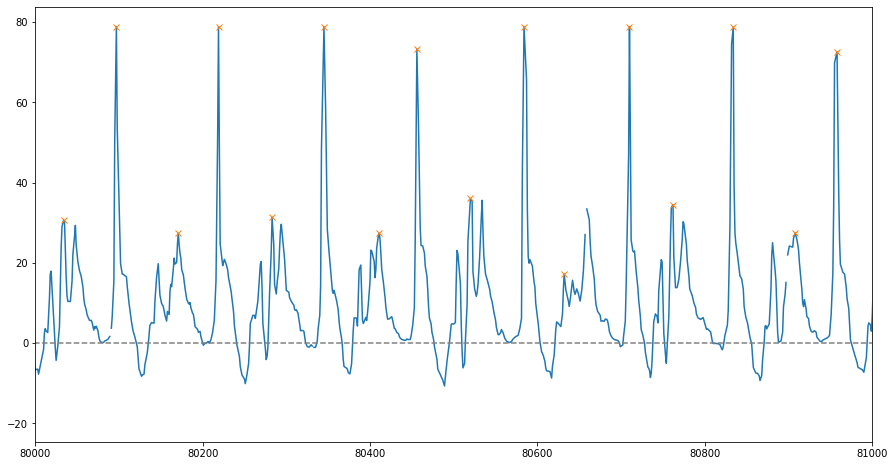

+++++++++++++++
Session Identifier:  11
Number of observations excluded with inference method: 4000


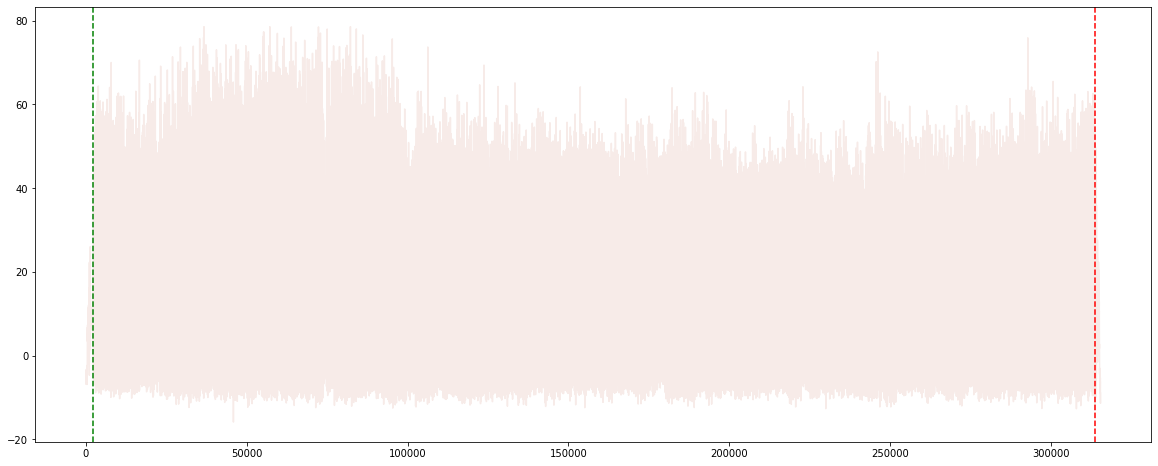

/home/stefano/Documents/University/Master/SL/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


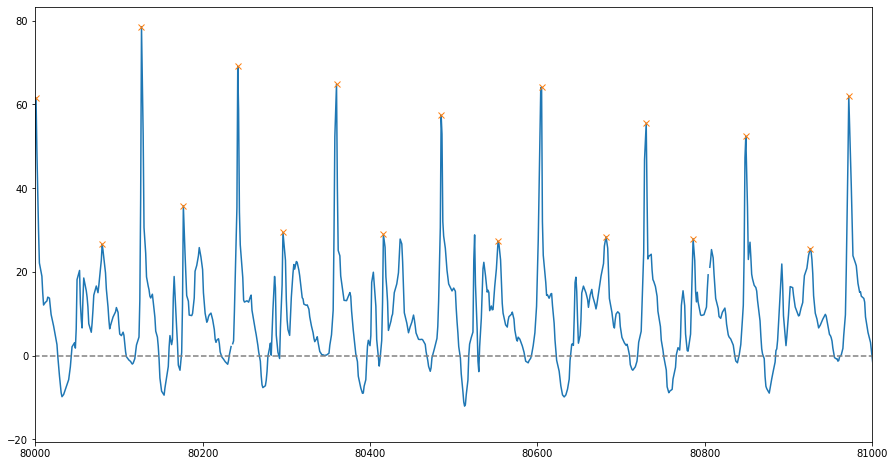

+++++++++++++++
Session Identifier:  15
Number of observations excluded with inference method: 3600


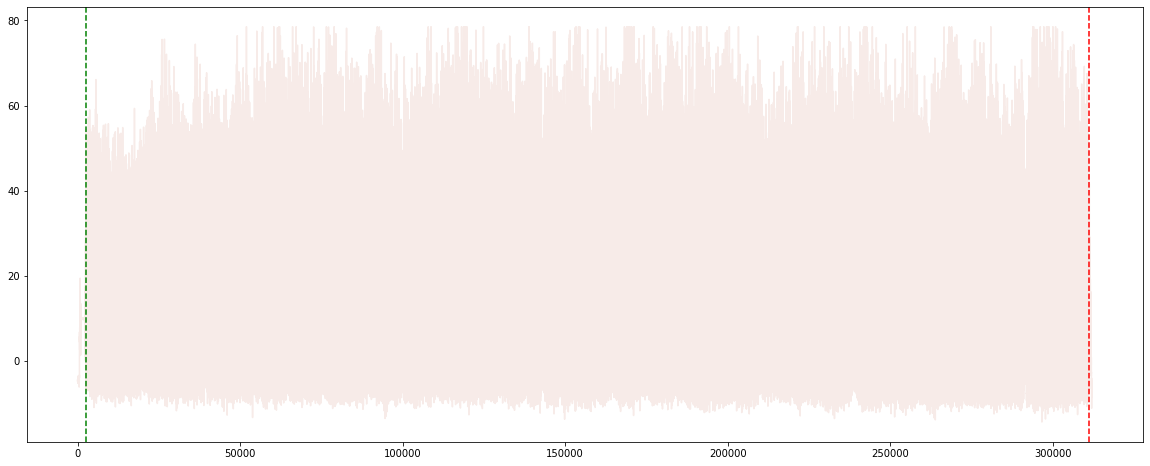

/home/stefano/Documents/University/Master/SL/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


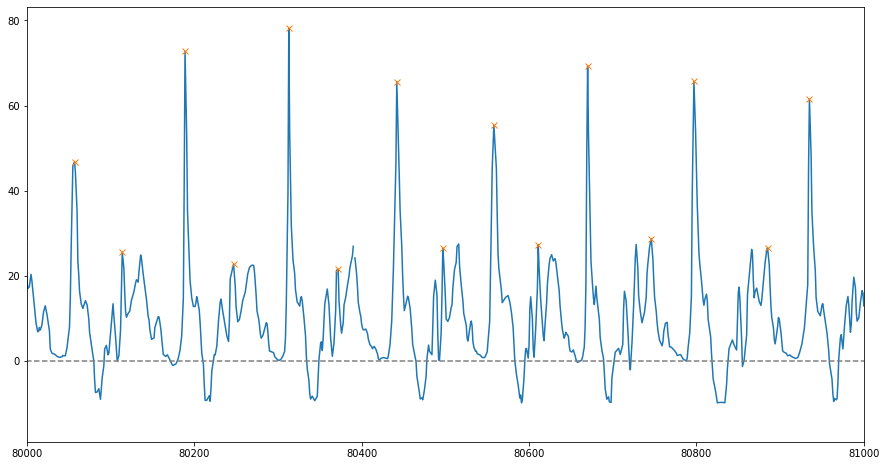

+++++++++++++++
Session Identifier:  1
Number of observations excluded with inference method: 6100


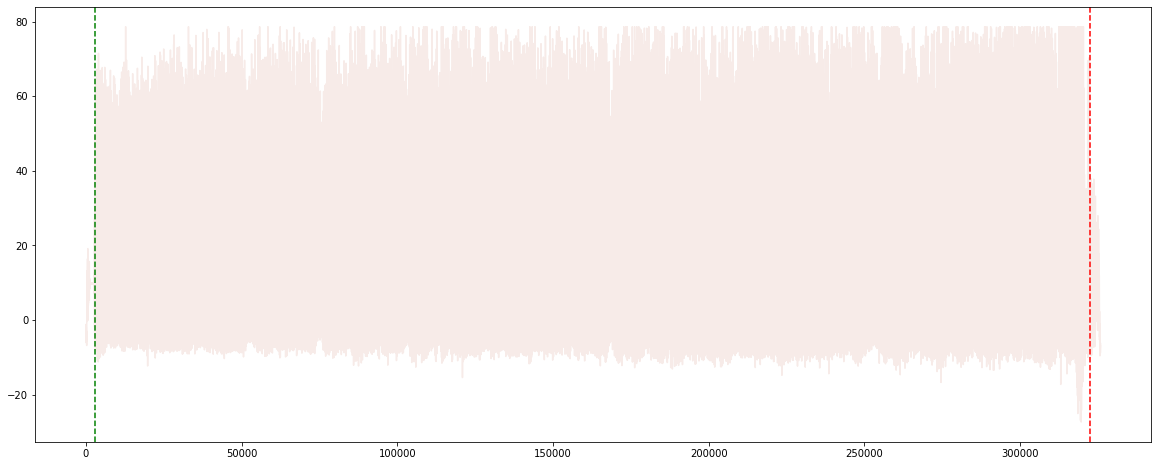

/home/stefano/Documents/University/Master/SL/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


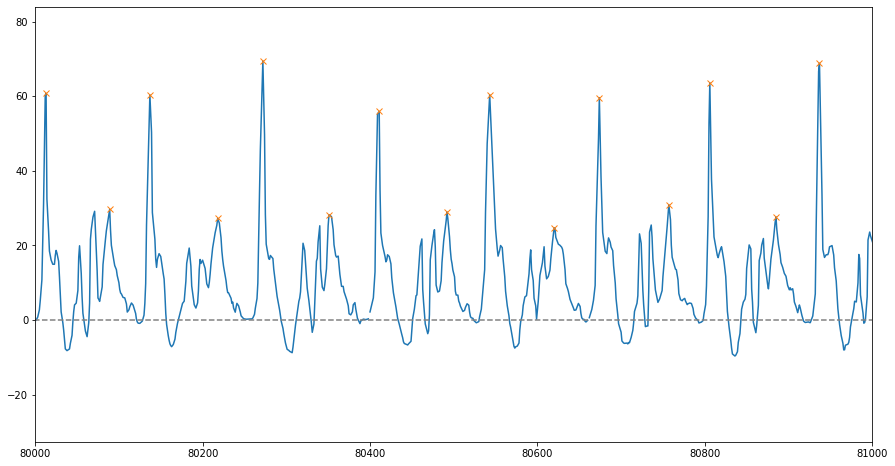

+++++++++++++++
Session Identifier:  21
Number of observations excluded with inference method: 1500


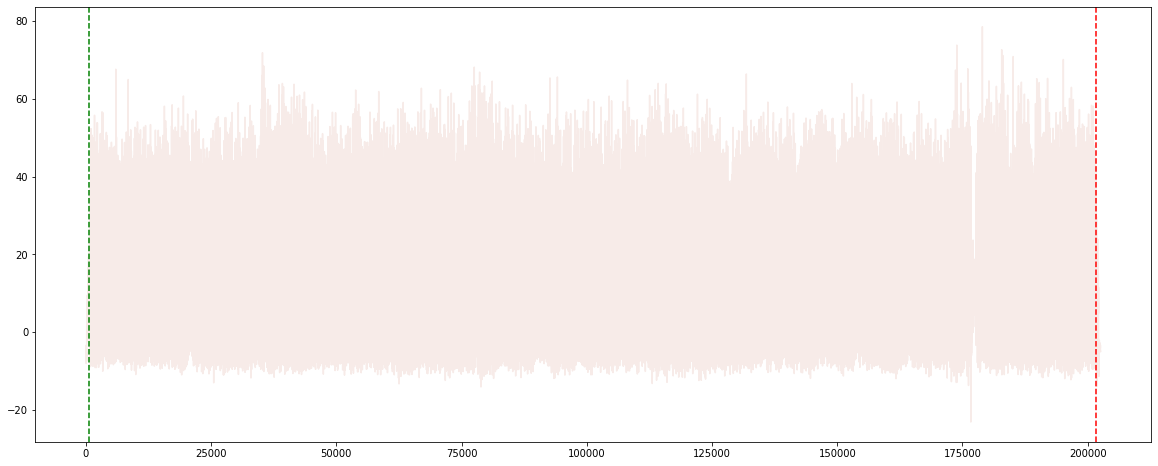

/home/stefano/Documents/University/Master/SL/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


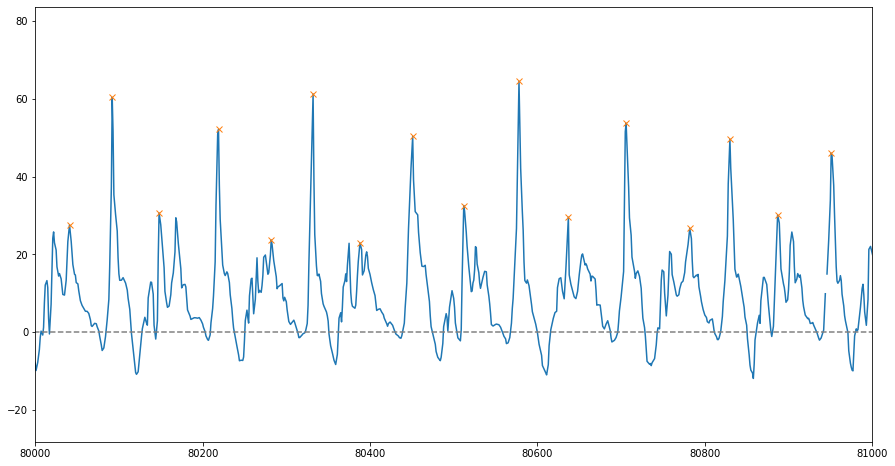

+++++++++++++++
Session Identifier:  20
Number of observations excluded with inference method: 3100


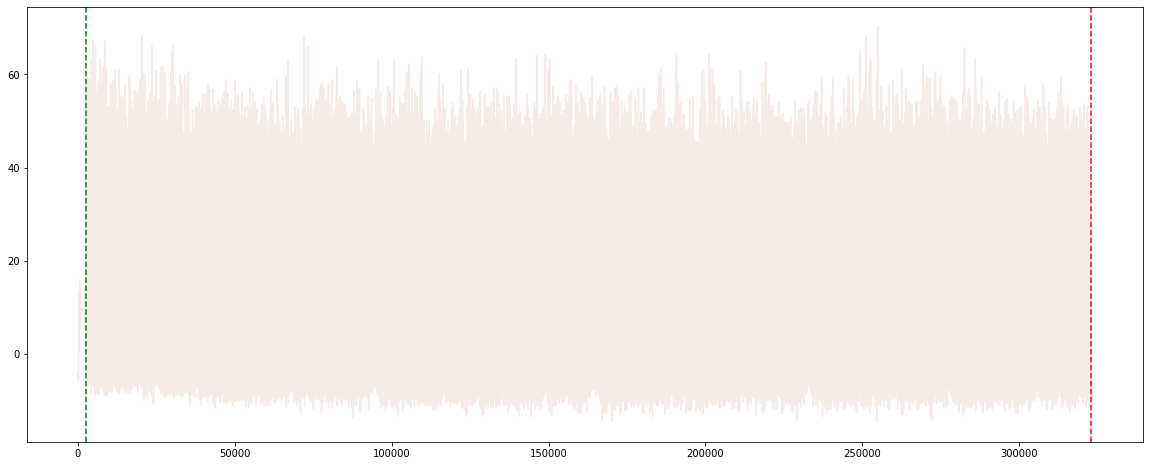

/home/stefano/Documents/University/Master/SL/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


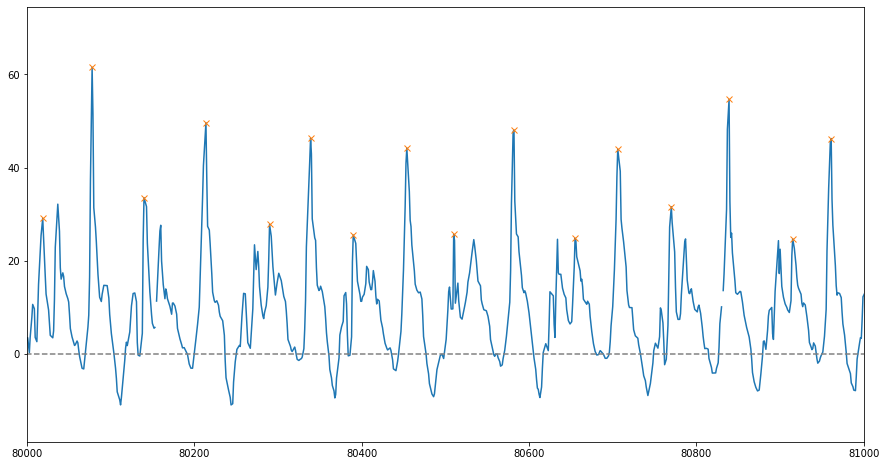

+++++++++++++++
Session Identifier:  19
Number of observations excluded with inference method: 5600


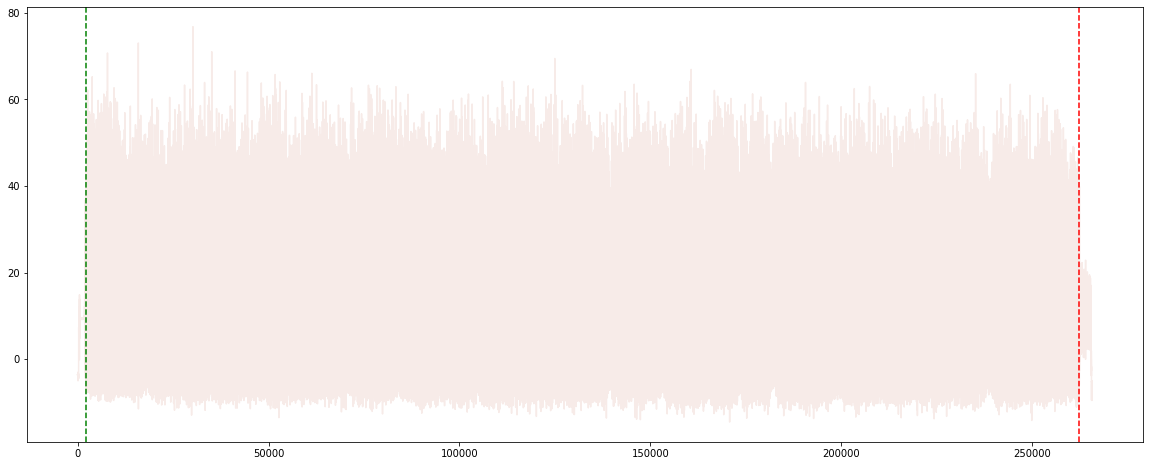

/home/stefano/Documents/University/Master/SL/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


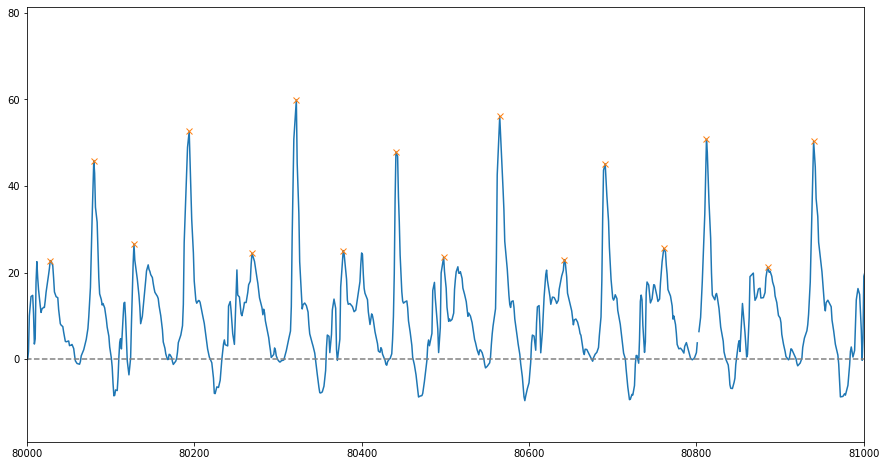

+++++++++++++++
Session Identifier:  10
Number of observations excluded with inference method: 3900


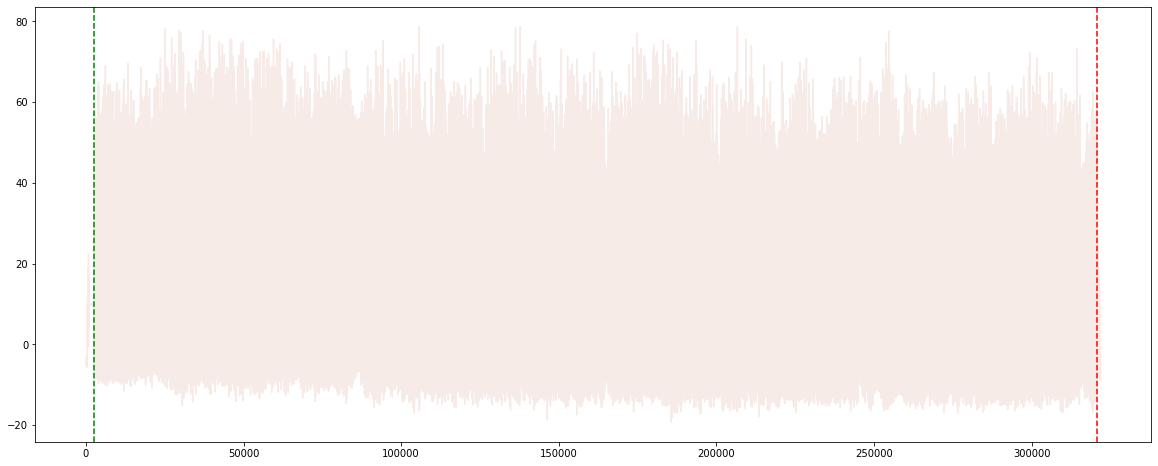

/home/stefano/Documents/University/Master/SL/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


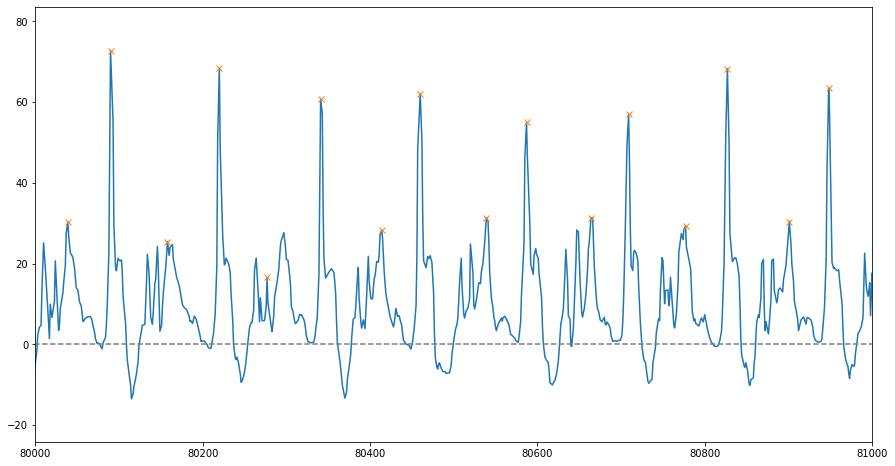

+++++++++++++++
Session Identifier:  18
Number of observations excluded with inference method: 2700


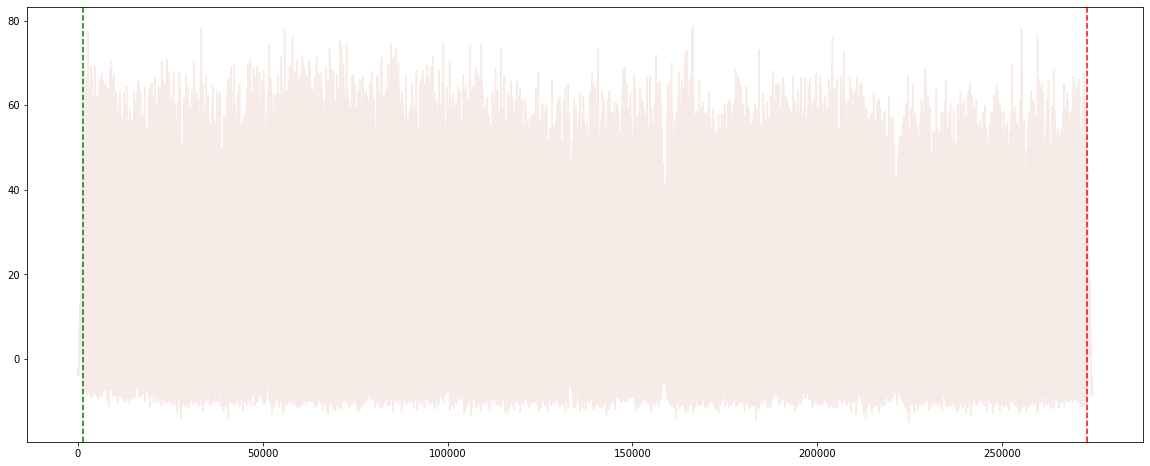

/home/stefano/Documents/University/Master/SL/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


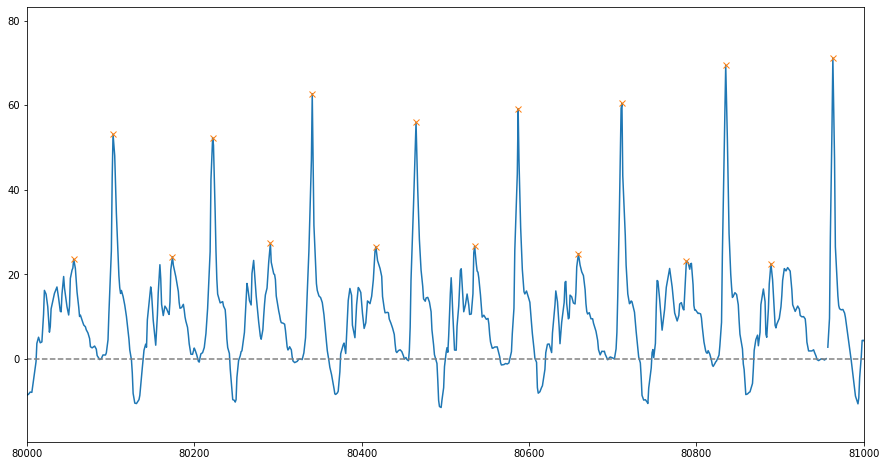

+++++++++++++++
Session Identifier:  13
Number of observations excluded with inference method: 2300


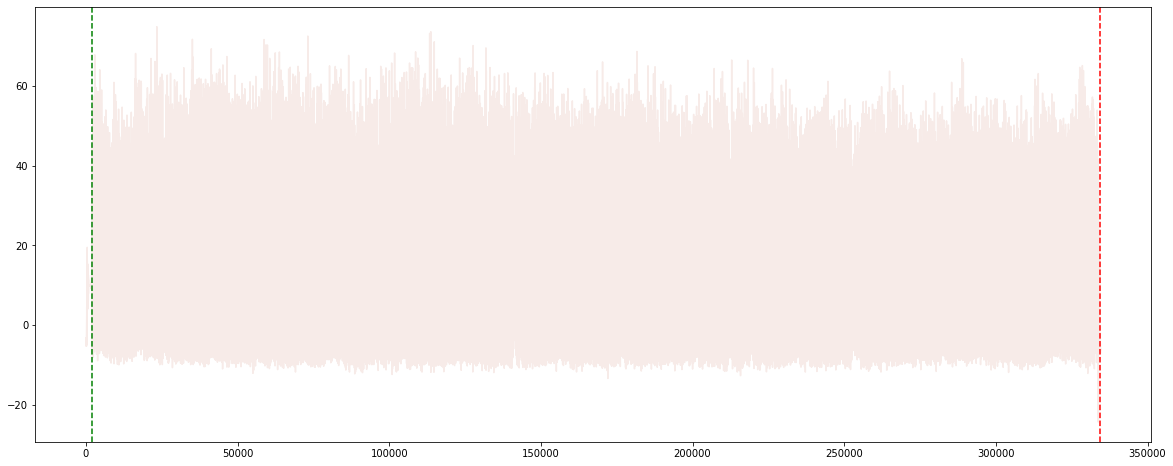

/home/stefano/Documents/University/Master/SL/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


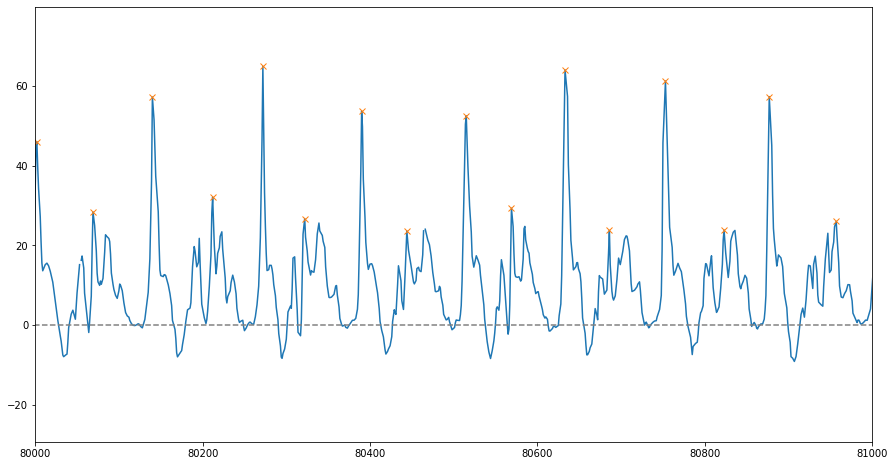

+++++++++++++++
Session Identifier:  6
Number of observations excluded with inference method: 3100


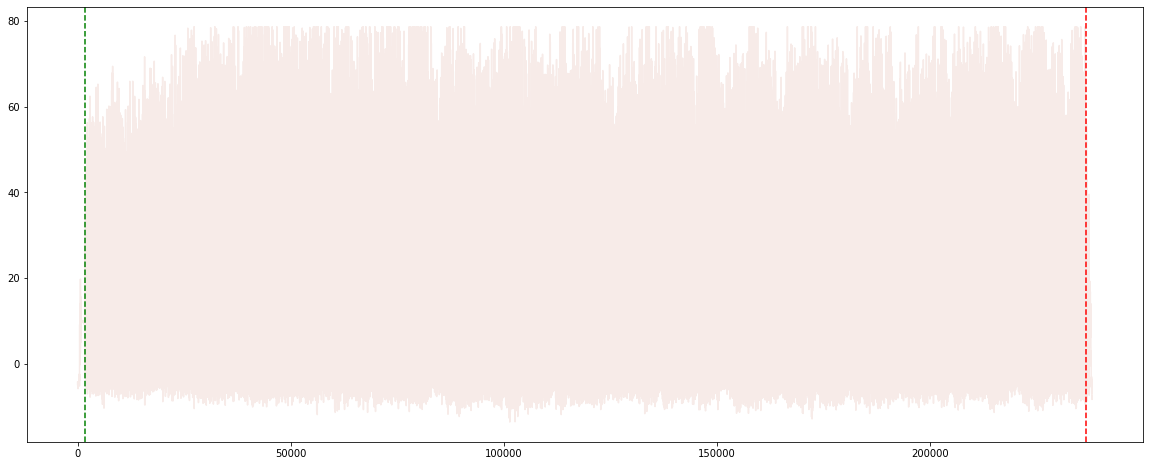

/home/stefano/Documents/University/Master/SL/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


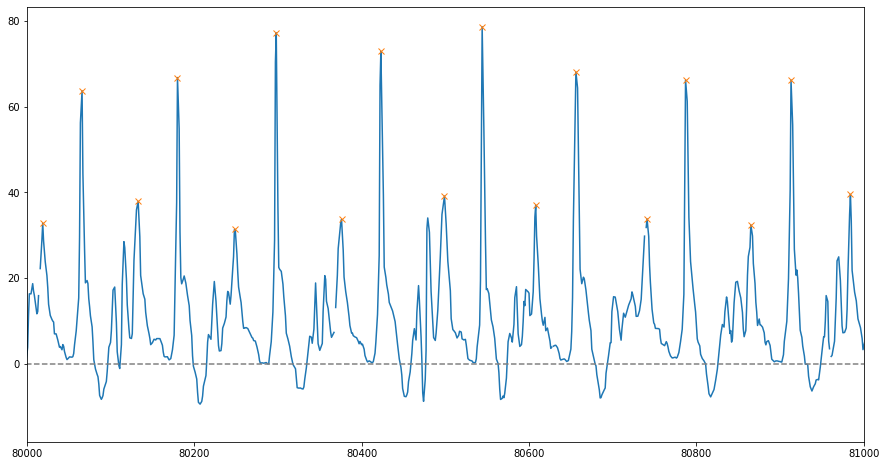

+++++++++++++++
Session Identifier:  22
Number of observations excluded with inference method: 3700


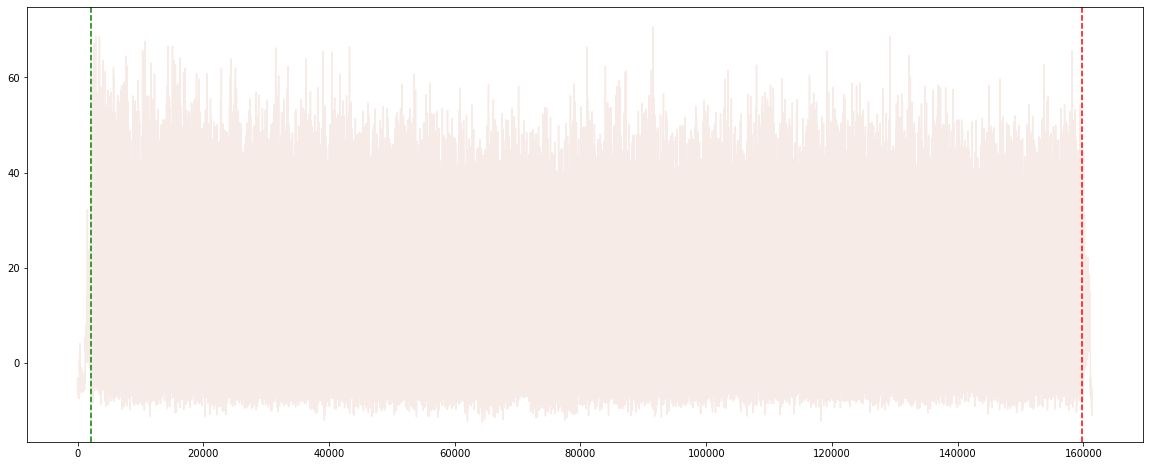

/home/stefano/Documents/University/Master/SL/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


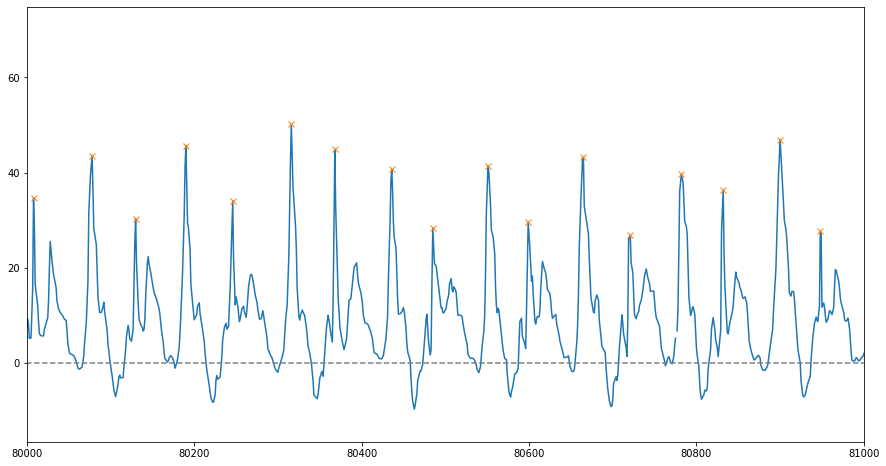

+++++++++++++++
Session Identifier:  16
Number of observations excluded with inference method: 6100


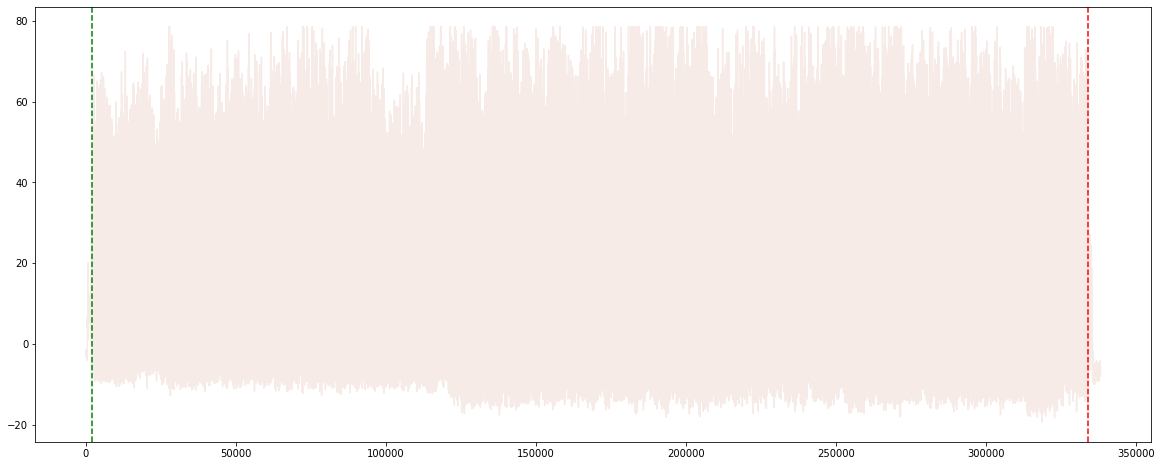

/home/stefano/Documents/University/Master/SL/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


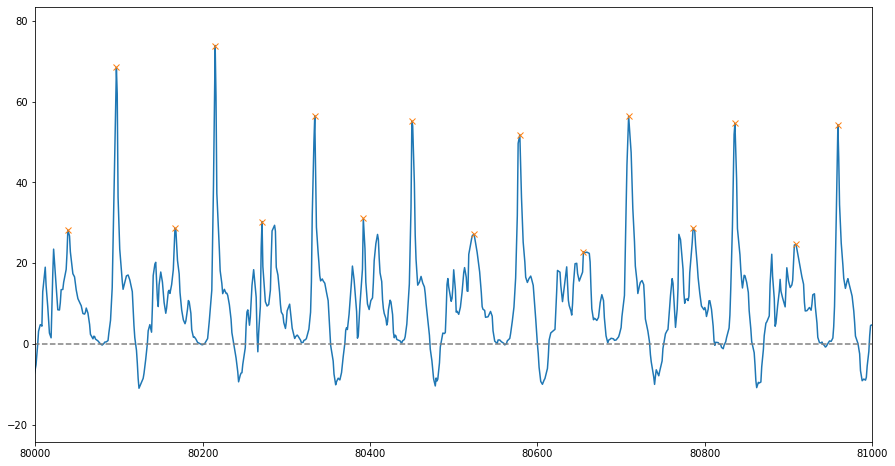

+++++++++++++++
Session Identifier:  14
Number of observations excluded with inference method: 2600


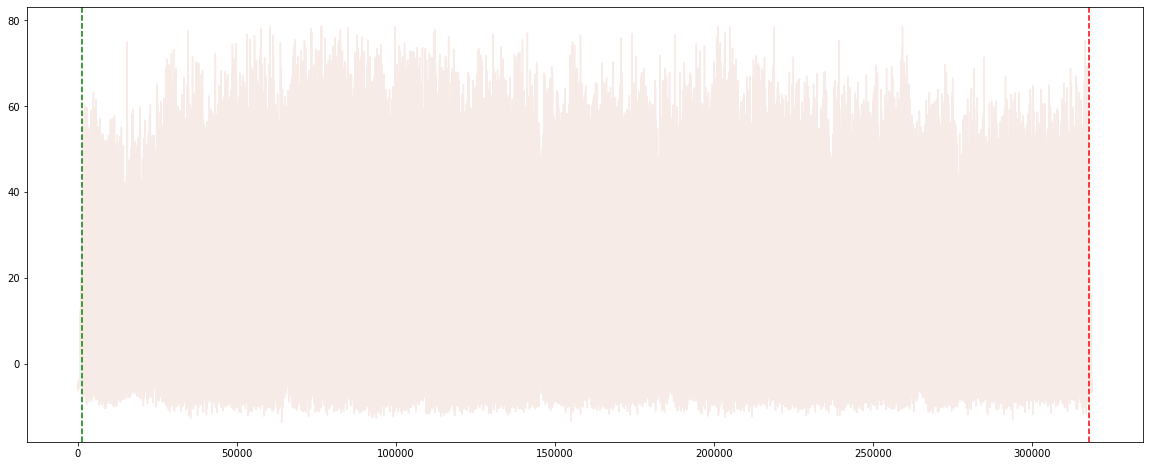

/home/stefano/Documents/University/Master/SL/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


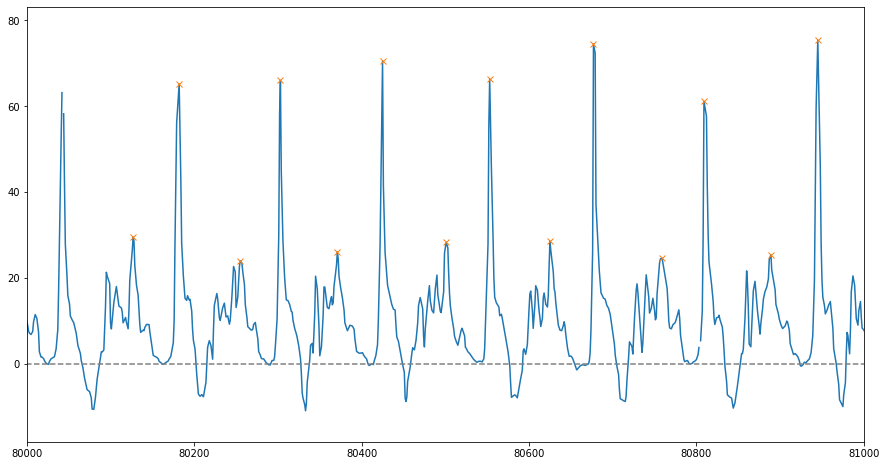

+++++++++++++++
Session Identifier:  7
Number of observations excluded with inference method: 2900


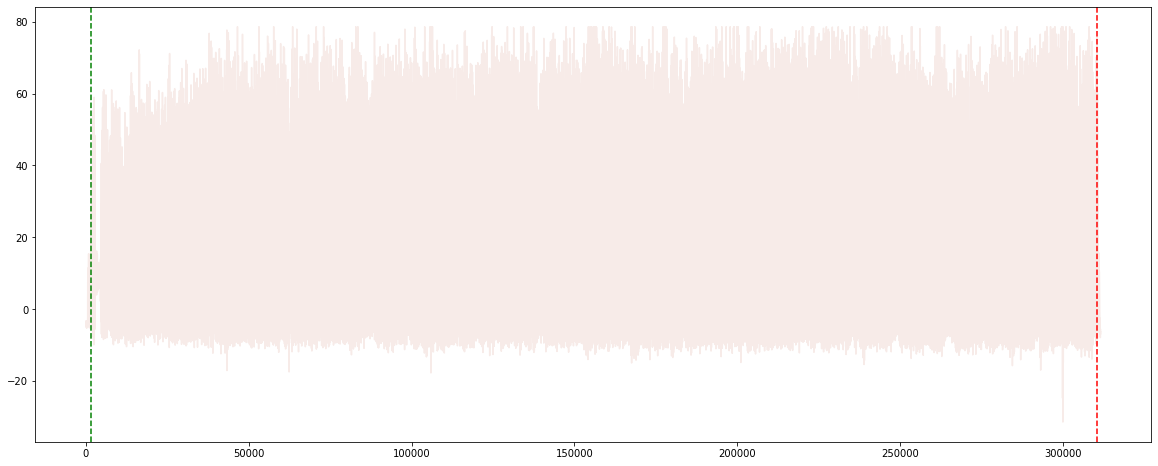

/home/stefano/Documents/University/Master/SL/.venv/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


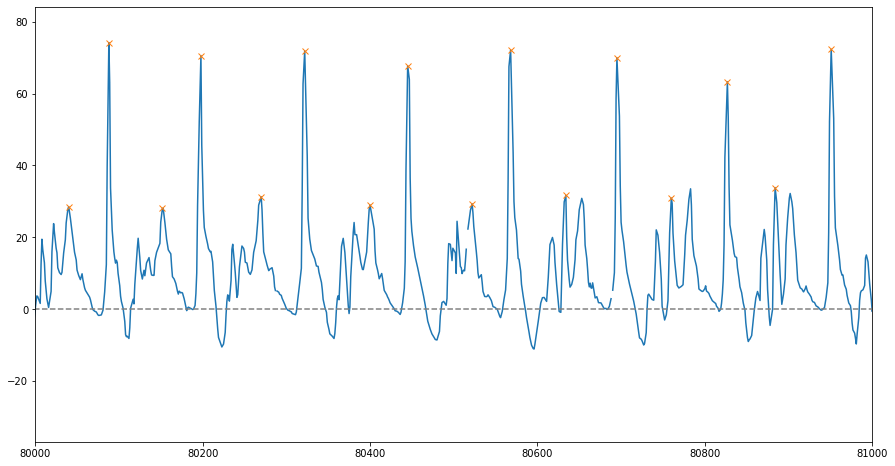

+++++++++++++++
Finished pre-processing individual time series


In [9]:
full = generate_full_time_series_AJ(paths_to_data['arduino'], time_interval='1S', independence_df=True, plot_check=[80000, 81000])

In [10]:
full.shape

(40208, 94)

In [11]:
full['step_sum'].value_counts()

3.0    23987
2.0    16082
1.0       91
4.0       30
0.0       18
Name: step_sum, dtype: int64

In [13]:
full = full[(full['pace_max'] <= 20) & (full['step_sum'] > 0)]
full.to_csv('../data/stefano_1s.csv')

### Models

#### Load data set

In [14]:
time_int = 1
who = 'stefano'

In [66]:
full = pd.read_csv(f'../data/{who}_{time_int}.csv', index_col=['timestamp'])
full.head()

Check the values of the `step_sum` variable

In [68]:
full['step_sum'].value_counts()

3.0    3115
2.0    1979
1.0     890
4.0     100
Name: step_sum, dtype: int64

In [69]:
full.shape

(6084, 139)

#### Grid search

In [15]:
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import json
from datetime import datetime

Define grid for the Random Forest, Gaussian Naive Bayes and SVM

In [71]:
# Gaussian Naive Bayes
params_grid_NB = {}


# Random Forest
params_grid_RF = {
    'n_estimators':[100,150,200,500],
    'criterion':['gini','entropy'],
    'max_depth':[10,20,30,1000,10000],
    'n_jobs':[-1],
    'class_weight':['balanced'],
    'random_state':[42]
    }


# SVM
params_grid_SVM = {
    'C':[0.1, 1, 10],
    'kernel':['linear', 'rbf'],
    'class_weight':['balanced'],
    'random_state':[42]
    }

Set up the grid search for the classifiers

In [72]:
def grid_search(estimator, params, X, y, n_folds=3): 
    """ 
    Grid search for the estimator in input. 
    """ 
    print('Encoding...') 
    lab_enc = LabelEncoder() 
    encoded = lab_enc.fit_transform(y['train']) 
    gs = GridSearchCV(estimator, params, cv=n_folds, n_jobs=-1, verbose=4) 
    print(f'>> Start grid search on {type(estimator).__name__}') 
    try: 
        gs.fit(X['train'], encoded) 
    except: 
        return (type(estimator).__name__, {},0,0) 
    y_pred = gs.best_estimator_.predict(X['test']) 
    encode_y_test = lab_enc.transform(y['test']) 
    res_tuple = ( str(type(estimator).__name__), 
                 gs.best_params_, gs.best_score_, 
                 accuracy_score(encode_y_test, y_pred), 
                 f1_score(encode_y_test, y_pred, average='weighted') ) 
    return res_tuple 
    

Prepare data

In [16]:
train_set, test_set = train_test_split(full, test_size=0.3, random_state=42)
X_train = train_set.drop(['step_sum'], axis=1)
y_train = train_set.step_sum
X_test = test_set.drop(['step_sum'], axis=1)
y_test = test_set.step_sum

X = {'train':X_train, 'test':X_test}
y = {'train':y_train, 'test':y_test}

List of classifiers, data and GridSearch

In [75]:
classifiers = {'RF':RandomForestClassifier, 
               'NB':GaussianNB,
               #'SVM':SVC
              }
params_grids = {'RF':params_grid_RF, 
                'NB':params_grid_NB,
                #'SVM':params_grid_SVM
               }

res_list = []

for cls_id in classifiers.keys():
    res = grid_search(classifiers[cls_id](), params_grids[cls_id], X, y, n_folds=3)
    res_list.append(res)
    
res_df = pd.DataFrame(res_list, columns=['Estimator', 'Best_params', 'Train_score', 'Test_score', 'F1'])

In [48]:
res_df

,Estimator,Best_params,Train_score,Test_score
0,RandomForestClassifier,"{'class_weight': 'balanced', 'criterion': 'ent...",0.811647,0.825849
1,GaussianNB,{},0.466414,0.450712


In [49]:
res_df.to_csv(f'../results/{time_int}s/results_{who}_{datetime.now()}.csv')

### Select the top features from Random Forest

Divide the train data into K-Folds (k=`n_splits`) and train the Random Forest classifier on each split. For trained model, get the importance scores of the features and rank the features according to them.

In [1]:
full = pd.read_csv('juan_1.csv')

NameError: name 'pd' is not defined

In [ ]:
train_set, test_set = train_test_split(full, test_size=0.3, random_state=42)
X_train = train_set.drop(['step_sum'], axis=1)
y_train = train_set.step_sum
X_test = test_set.drop(['step_sum'], axis=1)
y_test = test_set.step_sum

X = {'train':X_train, 'test':X_test}
y = {'train':y_train, 'test':y_test}

In [17]:
from sklearn.model_selection import KFold

In [24]:
def rank_features(X, y, best_params, n_splits=5, shuffle=True, rank_method='mean'):
    """
    Rank the features according to the importance the Random Forest classifier assigns to them.
    
    :param X: train data
    :param y: labels
    :param best_params: parameters of the Random Forest
    :param n_splits: number of folds
    :param shuffle: shuffle the data before split them into folds
    :param rank_method: either mean or median applied to the n_splits rankings
    
    :return list of ranked features
    """ 
    
    feature_positions = [[] for _ in range(0, X.shape[1])]
    feature_importances = np.array([0.0]*X.shape[1])
    
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=42)
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx,], X.iloc[test_idx,]
        y_train, y_test = y[train_idx], y[test_idx]
        
        rf_cls = RandomForestClassifier(**best_params)
        rf_cls.fit(X_train, y_train)
        feature_importances += rf_cls.feature_importances_
        f_rank_idx = np.argsort(rf_cls.feature_importances_)[::-1]
        
        for i in range(len(f_rank_idx)):
            feature_positions[f_rank_idx[i]].append(i)
    
    rank_methods = {'mean': np.mean, 'median':np.median}
    try:
        feature_positions = [rank_methods[rank_method](fp) for fp in feature_positions]
    except:
        print('Method not implemented')
    
    f_rank_idx = np.argsort(feature_positions)
    
    res_df = pd.DataFrame({'features':X.columns[f_rank_idx],
                               'importance':feature_importances[f_rank_idx] / n_splits
                              })
    
    return res_df

Load the best parameters for the Random Forest

In [20]:
result_files = glob.glob(f'../results/{time_int}s/results_{who}_*.csv')
result_grid = pd.read_csv(result_files[0])
best_param_rf = eval(result_grid[result_grid['Estimator'] == 'RandomForestClassifier']['Best_params'][0])

Get the ranking of the features

In [25]:
top_features = rank_features(X['train'], y['train'], best_param_rf, rank_method='mean')
top_features.head()

,features,importance
0,AccY_mean,0.097200
1,AccY_mean_previous_1,0.035009
2,AccY_median,0.028438
3,DecibelSource_mean,0.025860
4,pace_std,0.030405


Save the ranking in a file

In [27]:
top_features.to_csv(f'../results/{time_int}s/top_features_{who}.csv', index=False)

Check the importance values

<AxesSubplot:ylabel='features'>

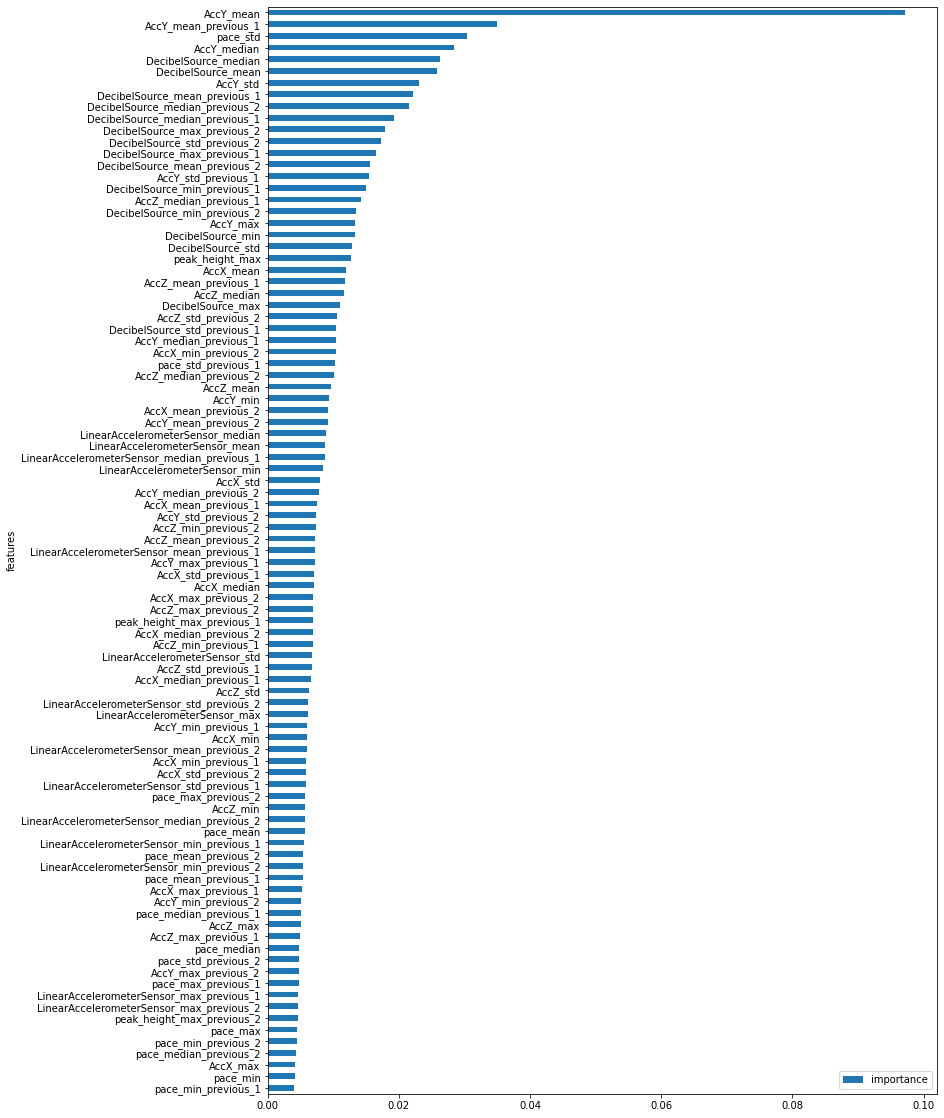

In [39]:
top_features.sort_values(by='importance', ascending=True)\
.plot(x='features', y='importance', kind='barh', figsize=(12,20))